In [1]:
#default_exp srresnet

# SRResNet: Photo-Realistic Single Image Super-Resolution using Generative Adversarial Network（CVPR2017, Oral）

https://arxiv.org/abs/1609.04802

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import cv2
import numpy as np
import re
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import PIL

In [4]:
# export
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [5]:
import sys
sys.path.append('..')
from superres.datasets import *
from superres.databunch import *

In [6]:
seed = 8610
random.seed(seed)
np.random.seed(seed)

## model

In [7]:
# https://qiita.com/pacifinapacific/items/ec338a500015ae8c33fe

In [8]:
#exort
class ResidualBlock(nn.Module):
    def __init__(self,input_channel):
        super(ResidualBlock,self).__init__()
        self.residualblock=nn.Sequential(
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel),
            nn.PReLU(),
            nn.Conv2d(input_channel,input_channel,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(input_channel))
        
    def forward(self,x):
        residual=self.residualblock(x)
        return x+residual

In [9]:
#export
class Pixcelshuffer(nn.Module):
    def __init__(self,input_channel,r): #r=upscale_factor
        super(Pixcelshuffer,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(input_channel,256,kernel_size=3,stride=1,padding=1), 
            nn.PixelShuffle(r),
            nn.PReLU())
        
    def forward(self,x):
        return self.layer(x)

In [10]:
#export
class SRResNet(nn.Module):
    
    def __init__(self,image_size):
        super(SRResNet,self).__init__()
        self.image_size = image_size

        self.pre_layer = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=9,stride=1,padding=4),
            nn.PReLU())

        self.residual_layer = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64))

        self.middle_layer = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64))

        self.pixcelshuffer_layer=nn.Sequential(
            Pixcelshuffer(64,2),
            Pixcelshuffer(64,2),
            nn.Conv2d(64,3,kernel_size=9,stride=1,padding=4))

    def forward(self,input_image):
        pre = self.pre_layer(input_image)
        res = self.residual_layer(pre)
        middle = self.middle_layer(res)
        middle = middle+pre
        output = self.pixcelshuffer_layer(middle)
        return output

In [11]:
test_input=torch.ones(1,3,64,64)
g=SRResNet(64)
test_input=test_input.cuda()
g=g.cuda()
out=g(test_input)
print(out.size())

torch.Size([1, 3, 256, 256])


## DataBunch

In [12]:
train_hr = div2k_train_hr_crop_256

In [13]:
in_size = 64
out_size = 256
scale = 4
bs = 8

ImageDataBunch;

Train: LabelList (25245 items)
x: ImageImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Valid: LabelList (6311 items)
x: ImageImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Test: None


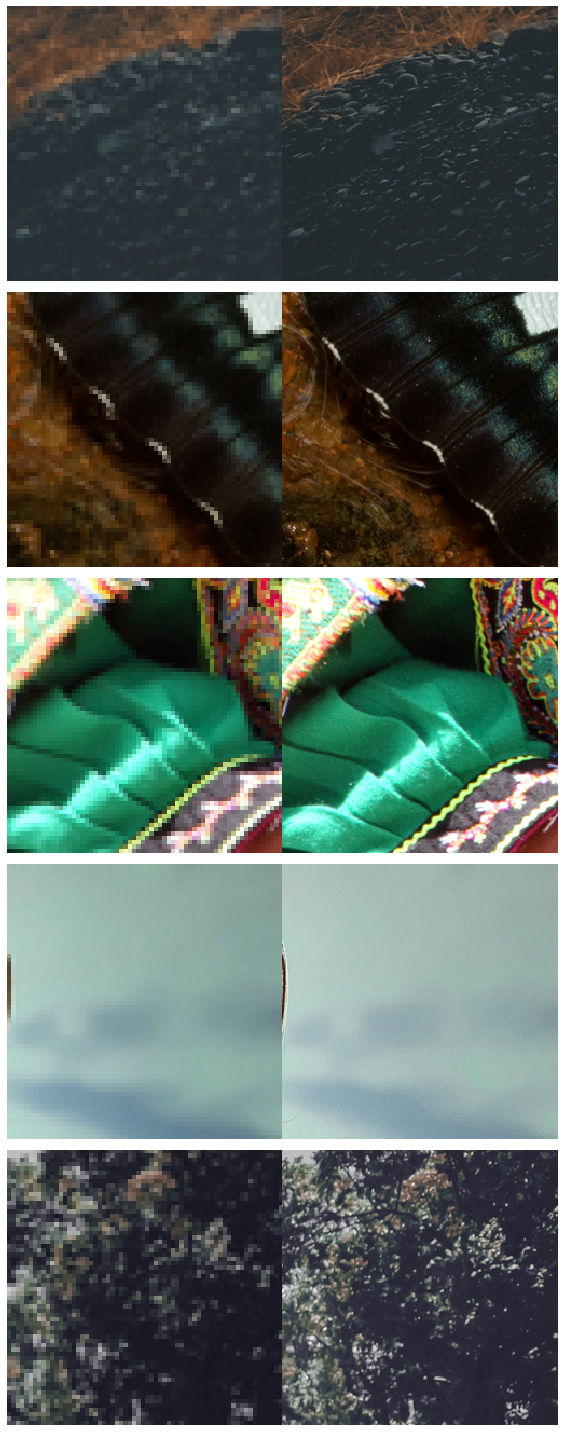

In [14]:
data = create_sr_databunch(train_hr, in_size=in_size, out_size=out_size, scale=scale, bs=bs, seed=seed)
print(data)
data.show_batch()

## Training

In [15]:
model = SRResNet(64)
loss_func = MSELossFlat()
metrics = [m_psnr, m_ssim]
learn = Learner(data, model, loss_func=loss_func, metrics=metrics)
learn.path = Path('.')
model_name = model.__class__.__name__

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 3.63E-04


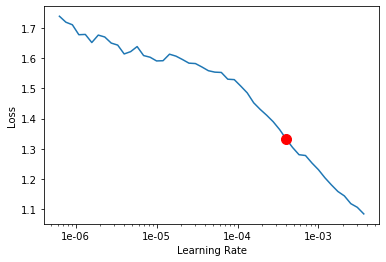

In [16]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [17]:
lr = 1e-3
lrs = slice(lr)
epoch = 3
pct_start = 0.3
wd = 1e-3
save_fname = model_name

In [18]:
callbacks = [ShowGraph(learn), SaveModelCallback(learn, name=save_fname)]

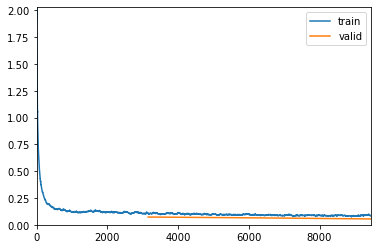

Better model found at epoch 0 with valid_loss value: 0.07248980551958084.
Better model found at epoch 1 with valid_loss value: 0.06438024342060089.
Better model found at epoch 2 with valid_loss value: 0.054595768451690674.


In [19]:
learn.fit_one_cycle(epoch, lrs, pct_start=pct_start, wd=wd, callbacks=callbacks)

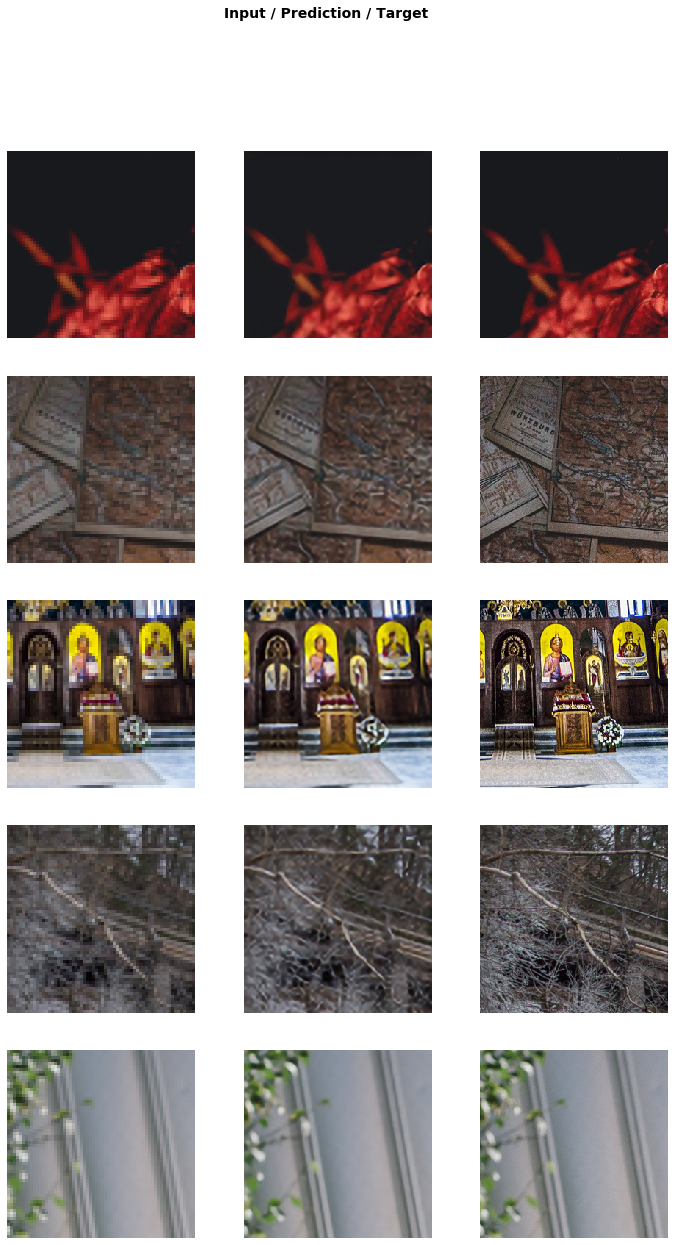

In [20]:
learn.show_results()

## Test

In [21]:
test_hr = set14_hr

In [28]:
il_test_x = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=in_size, scale=4,))
il_test_y = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=out_size))
il_test_x_up = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=out_size, scale=4, sizeup=True))

bicubic: PSNR:24.11,SSIM:0.7822
SRResNet:	 PSNR:23.81,SSIM:0.7822


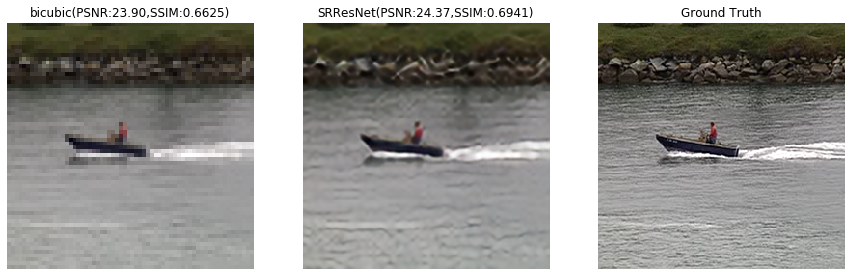

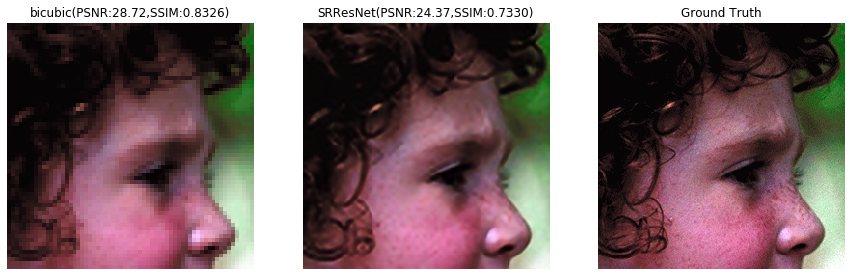

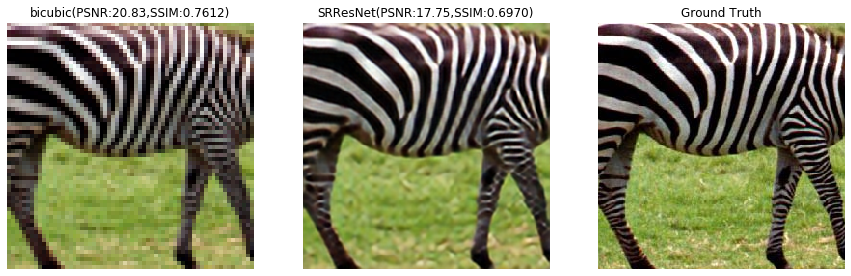

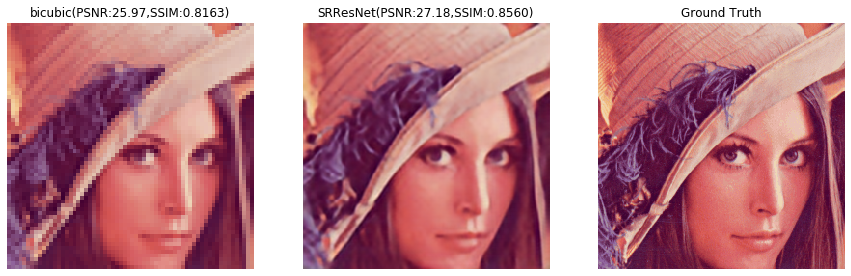

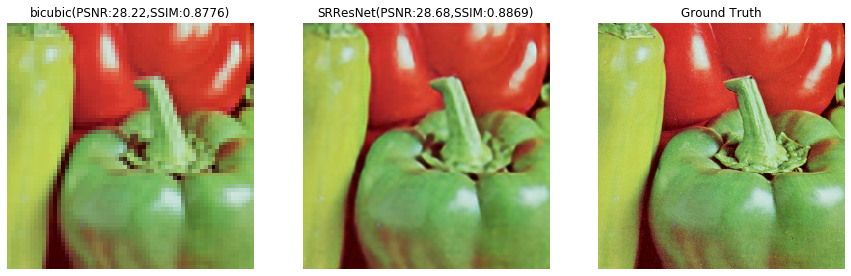

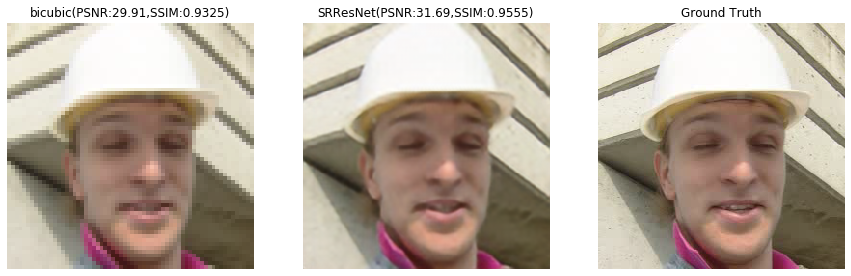

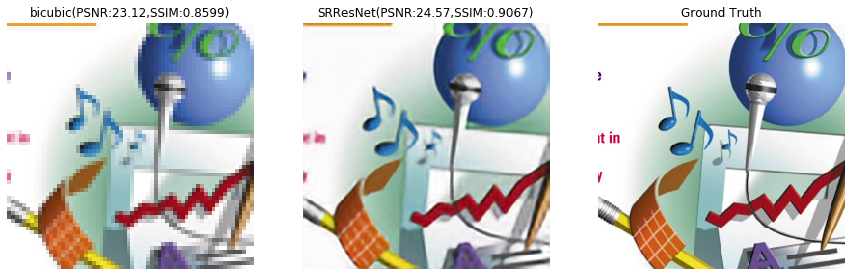

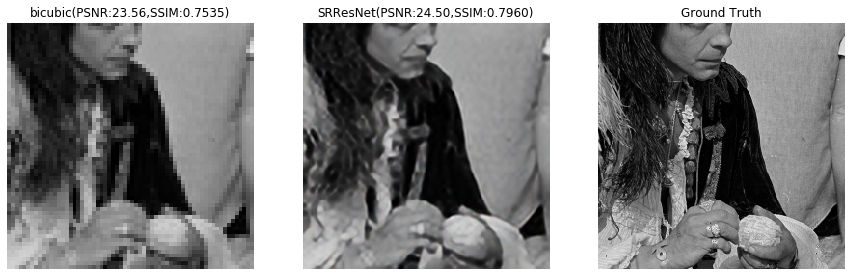

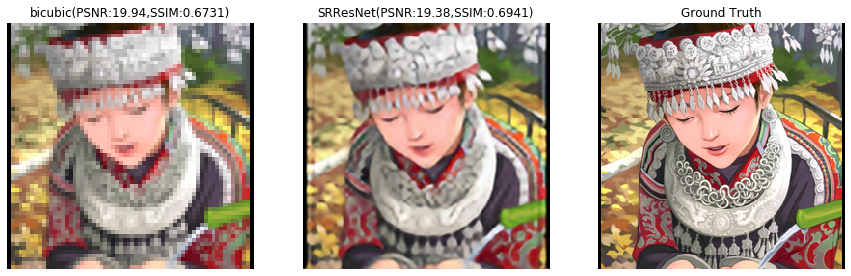

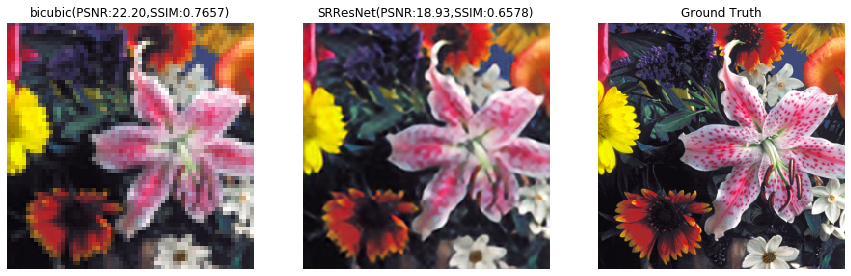

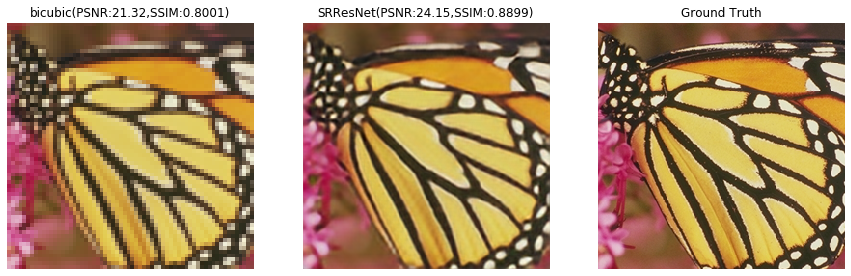

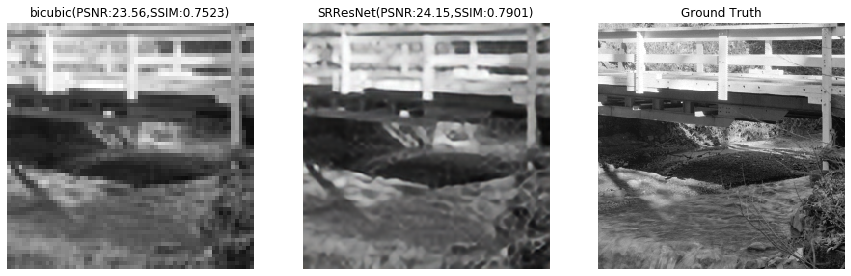

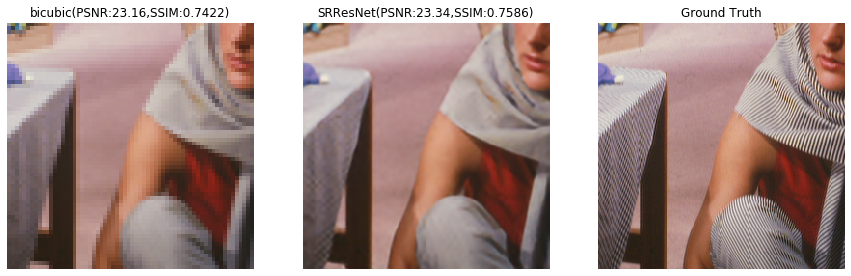

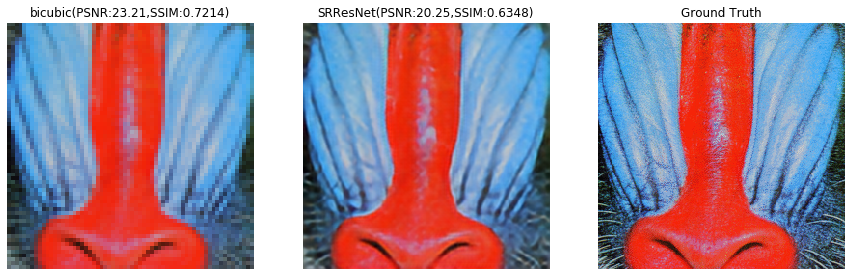

In [29]:
sr_test_upscale(learn, il_test_x, il_test_y, il_test_x_up, model_name)

## Report

In [26]:
model

SRResNet(
  (pre_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (residual_layer): Sequential(
    (0): ResidualBlock(
      (residualblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (residualblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchN

In [27]:
learn.summary()

SRResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         15,616     True      
______________________________________________________________________
PReLU                [64, 64, 64]         1          True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,928     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
PReLU                [64, 64, 64]         1          True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,928     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
_____________________________________________________